### Regularizing the Greedy Methods
So far, we have been investigating methods that aim to minimize the mean squared error on the training data. However, this implies that we heavily overfit on the training data, and hence, we get that the matrix performs well on this data, but poorly on some other data that has been generated in the exact same way.

Therefore, we should verify MSE on another independent training set.

How to regularize:
- During the computations.
    - Break when all coefficients are below a certain *tolerance*. Again, we can have multiple kinds of tolerances.
        - Largest correlation with residual. Easy to compute.
        - Two-norm of the current residual. Difficult, do not know the minimum before hand.
        - Visual inspection. 
        - Coefficient size. Again, coefficient is not very good.
- After the computations.
    - Thresholding coefficient values. We can threshold based on several metrics.
        - Correlation with residual when we exclude the edge.
        - Two norm after excluding the edge.
        - Simply set all edges with an absolute value smaller than $\texttt{tol}$ to be equal to zero.
    - Bootstrapping.
        - Resample, based on difference in two norm. 
        
More formal. A greedy method generally yields a matrix $W$. However, the nine greedy methods yield a *set* of matrices $\mathcal{W}= \{W_0, W_1, \ldots, W_K\}$. The index indicates the number of edges, and also the importance of the edges. At each iteration $k$, we add an edge to the matrix $W_{k-1}$, which yields the matrix $W_k$. The edge that is added corresponds to the edge that is the most important out of all possible edges. Naturally, on the training data, we have the ordering 

$$\texttt{MSE}(W_{k - 1}) \leq \texttt{MSE}(W_k)\ \forall k = 1, \ldots, K.$$

How unimportant an edge is, it will never decrease the mean squared error on the training data, and almost always increase it. However, we also want our greedy method to *generalize*, in other words, achieve a low MSE on similarly generated data. This means that we must not *overfit* on the data.

So, we are looking for a regularizing method such that we can pick a suitable $W_k$ from $\mathcal{W}$.

In [279]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("..")

import helper.helper as h
import helper.methods as m

from notears.notears.notears import utils 

from importlib import reload  # Python 3.4+

In [128]:
reload(m)

<module 'helper.methods' from '..\\helper\\methods.py'>

In [242]:
p, s, T = 5, 10, 1000
A_true = h.generate_A(p, s, low = 0.5, high = 0.75)
X = h.generate_var_2(T, p, A_true, np.identity(p))

True W:
[[ 0.    0.    0.    0.    0.  ]
 [-0.64  0.68  0.    0.    0.  ]
 [ 0.74  0.    0.64  0.    0.  ]
 [ 0.6  -0.68  0.   -0.63  0.  ]
 [ 0.    0.71  0.68 -0.59  0.  ]].
Estimated W:
[[-0.03  0.    0.    0.    0.  ]
 [-0.66  0.67  0.    0.    0.  ]
 [ 0.78  0.03  0.63  0.    0.  ]
 [ 0.57 -0.7  -0.04 -0.64  0.  ]
 [-0.02  0.77  0.67 -0.56  0.03]].
5.015893689294374
5.002063842631173


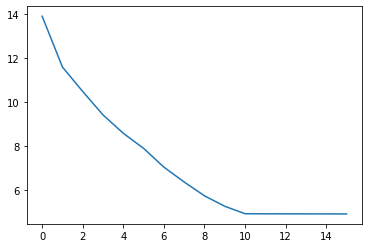

In [245]:
W_KOMP, _ = m._K_OMP(X[:-1], X[1:], normalize = True, F = [])
W_OMP, Ws, MSEs, max_gains = m._OMP_2(X[:-1], X[1:], output = True)
print(f"True W:\n{np.round(A_true, 2)}.")
print(f"Estimated W:\n{np.round(W_KOMP, 2)}.")

plt.plot(MSEs)

X_2 = h.generate_var_2(T, p, A_true, np.identity(p))
print(h.MSE(W_KOMP, X_2))
print(h.MSE(A_true, X_2))

## Post Process Methods
### Criterion per edge
#### Regularize Based on Threshold

In [234]:
def reg_coef(W, threshold):
    # create copy
    W_return = W.copy()
    
    # threshold values
    W_return[np.abs(W_return) <= threshold] = 0
    
    # return matrix
    return W_return

print(np.round(reg_coef(W_OMP, 0.3), 2))

[[ 0.99  0.    0.    0.    0.  ]
 [ 0.74 -0.56  0.   -0.41  0.  ]
 [ 1.09  0.    0.36  0.    0.  ]
 [ 0.    0.    0.    0.    0.  ]
 [ 0.   -0.51  0.    0.   -0.68]]


#### Threshold with respect to increase in MSE

In [235]:
def reg_MSE(W, X, threshold, verbose = False):
    
    W_temp = W.copy()
    stop = False
    
    # iteratively remove edges until all edges yield MSE increase greater than threshold
    while len(W_temp[W_temp != 0]) > 0:
        
        MSE_current = h.MSE(W_temp, X)
        MSE_remove = np.inf
        edge_remove = None
        
        for row, col in np.argwhere(W_temp != 0):
            
            # temporarily remove edge
            tmp = W_temp[row][col]
            W_temp[row][col] = 0

            # compute MSE
            MSE_temp = h.MSE(W_temp, X)

            # check if it is the least important edge
            if MSE_temp < MSE_remove:
                MSE_remove = MSE_temp
                edge_to_remove = [row, col]
                
            # checking is done, try new matrix
            W_temp[row][col] = tmp
        
        if verbose: print(f"Removing edge {edge_to_remove} yields the smallest increase in MSE of {np.round(MSE_remove - MSE_current, 1)}.")
        
        # remove least important edge
        if MSE_remove - MSE_current >= threshold:
            if verbose: print(f"Loss in MSE is larger than threshold. We terminate.")
            return W_temp
        
        else:
            
            # remove entry
            row, col = edge_to_remove
            W_temp[row][col] = 0
            
            # update column
            idx = np.nonzero(W_temp[:, col])[0]
            W_temp[idx, col] = (np.linalg.inv(X[:-1, idx].T @ X[:-1, idx]) @ X[:-1, idx].T @ X[1:, col])
    
    print("Empty Graph! All edges were not important enough.")
    return W_temp
    
print(np.round(reg_MSE(W_KOMP, X, 0.1), 1))

[[ 1.   0.   0.  -0.2  0. ]
 [ 0.7 -0.6  0.  -0.5  0. ]
 [ 1.1  0.   0.4  0.   0. ]
 [ 0.   0.   0.   0.   0. ]
 [-0.3 -0.5  0.   0.  -0.7]]


#### Threshold with respect to correlation with residual

In [125]:
def normalize(x): return x / np.linalg.norm(x)

In [126]:
def gain(W, X, i, j):
    
    return np.abs(normalize(X[:-1, i]) @ (X[1:, j] - (X[:-1] @ W)[:, j]))

In [236]:
def reg_OMP(W, X, threshold, verbose = False):
    
    W_temp = W.copy()
    stop = False
    
    # iteratively remove edges until all edges yield MSE increase greater than threshold
    while len(W_temp[W_temp != 0]) > 0:
        
        resid_remove = np.inf
        edge_remove = None
        
        for row, col in np.argwhere(W_temp != 0):
            
            # temporarily remove edge
            tmp = W_temp[row][col]
            W_temp[row][col] = 0

            # compute MSE
            resid_temp = gain(W_temp, X, row, col)

            # check if it is the least important edge
            if resid_temp < resid_remove:
                resid_remove = resid_temp
                edge_to_remove = [row, col]
                
            # checking is done, try new matrix
            W_temp[row][col] = tmp
        
        if verbose: print(f"Removing edge {edge_to_remove} yields the smallest residual correlation of {np.round(resid_remove, 1)}.")
        
        # remove least important edge
        if resid_remove >= threshold:
            if verbose: print(f"Loss in residual correlation is larger than threshold. We terminate.")
            return W_temp
        else:
            # remove entry
            row, col = edge_to_remove
            W_temp[row][col] = 0
            
            # update column
            idx = np.nonzero(W_temp[:, col])[0]
            W_temp[idx, col] = (np.linalg.inv(X[:-1, idx].T @ X[:-1, idx]) @ X[:-1, idx].T @ X[1:, col])

    print("Empty Graph! All edges were not important enough.")
    return W_temp
    
print(np.round(reg_OMP(W_KOMP, X, 0), 2))

[[ 0.99  0.    0.   -0.18  0.  ]
 [ 0.74 -0.56  0.11 -0.41  0.  ]
 [ 1.09  0.    0.36 -0.01  0.  ]
 [ 0.    0.    0.   -0.2   0.  ]
 [-0.29 -0.51 -0.26 -0.   -0.68]]


### Criterion on total matrix $W$

#### Maximum number of edges

#### Minimum MSE on Training Data

## Bootstrapping

# Compare all methods

W_true:
MSE on training set:	 5.2
MSE on test set:	 5.8

W_OMP:
MSE on training set:	 3.3
MSE on test set:	 10.1
[[ 0.25098115  0.          0.          0.          0.        ]
 [-0.29976238  0.          0.          0.          0.        ]
 [ 0.27029378  0.         -0.25433665  0.          0.        ]
 [ 0.         -0.27805617 -0.29579528  0.28599757  0.        ]
 [ 0.25788345  0.          0.2896086  -0.25842586  0.        ]]
[[[ 0.    0.    0.    0.    0.  ]
  [ 0.    0.    0.    0.    0.  ]
  [ 0.    0.   -0.5   0.    0.  ]
  [ 0.    0.    0.    0.    0.  ]
  [ 0.    0.    0.    0.    0.  ]]

 [[ 0.    0.    0.   -0.67  0.  ]
  [ 0.    0.    0.    0.    0.  ]
  [ 0.    0.   -0.5   0.    0.  ]
  [ 0.    0.    0.    0.    0.  ]
  [ 0.    0.    0.    0.    0.  ]]

 [[ 0.    0.    0.   -0.67  0.  ]
  [ 0.    0.    0.    0.    0.  ]
  [ 0.    0.   -0.5   0.    0.  ]
  [ 0.    0.    0.    0.    0.  ]
  [ 0.66  0.    0.    0.    0.  ]]

 [[ 0.    0.    0.   -0.67  0.  ]
  [ 0.    0.    0.   

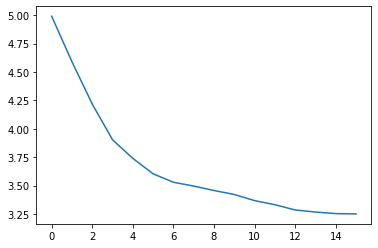

In [374]:
## Generate data
p, s, T = 5, 10, 10
W_true = h.generate_A(p, s, low = 0.25, high = 0.3)
X = h.generate_var_2(T, p, W_true, np.identity(p))

# Infer matrix using OMP
W_OMP, Ws, MSEs, max_gains = m._OMP_2(X[:-1], X[1:], output = True)

# Generate similar data
X_2 = h.generate_var_2(T, p, W_true, np.identity(p))

## We already see: performs well on training, bad on test
print("W_true:\nMSE on training set:\t", np.round(h.MSE(W_true, X), 1))
print("MSE on test set:\t", np.round(h.MSE(W_true, X_2), 1))

print("\nW_OMP:\nMSE on training set:\t", np.round(h.MSE(W_OMP, X), 1))
print("MSE on test set:\t", np.round(h.MSE(W_OMP, X_2), 1))

plt.plot(MSEs)

print(W_true)
print(np.round(Ws, 2))

In [263]:
coef_size = 0.3
print(f"Regularize using coefficient size with threshold {coef_size}:\nMSE on training set:\t{np.round(h.MSE(reg_coef(W_OMP, coef_size), X), 1)}.\nMSE on test set:\t{np.round(h.MSE(reg_coef(W_OMP, coef_size), X_2), 1)}.\n")

threshold = 0.5
print(f"Regularize using MSE with threshold {threshold}:\nMSE on training set:\t{np.round(h.MSE(reg_MSE(W_OMP, X, threshold), X), 1)}.\nMSE on test set:\t{np.round(h.MSE(reg_MSE(W_OMP, X, threshold), X_2), 1)}.\n")

threshold = 5
print(f"Regularize using residual correlation, with threshold {threshold}:\nMSE on training set:\t{np.round(h.MSE(reg_OMP(W_OMP, X, threshold), X), 1)}.\nMSE on test set:\t{np.round(h.MSE(reg_OMP(W_OMP, X, threshold), X_2), 1)}.")

Regularize using coefficient size with threshold 0.3:
MSE on training set:	3.1.
MSE on test set:	6.5.

Regularize using MSE with threshold 0.5:
MSE on training set:	5.0.
MSE on test set:	8.4.

Regularize using residual correlation, with threshold 5:
MSE on training set:	5.6.
MSE on test set:	11.1.


### Metric: AUC
We have a threshold that we can vary from zero until infinity. At zero, we simply do not regularization and at infinity, we regularize out all edges. We can calculate the true positive rate (tpr) as a function of this threshold, i.e., how many edges that we detect were actually true after regularizing? Furthermore, we can also compute the false positive rate as a function of this threshold, i.e., how many edges that we detect were actually false after regularizing? This AUC says something important. Clearly, when our threshold is infinity, we detect no edges whatsoever, so our true positive rate is 1, and our false positive rate is 1 by definition.

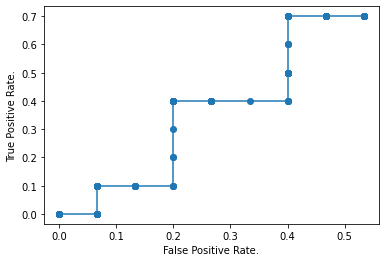

In [375]:
coefs = np.linspace(0, 2, 500)
tprs, fprs = [], []

B_true = (W_true != 0).flatten()

for coef in coefs:
    B_OMP = (reg_coef(W_OMP, coef) != 0).flatten()
    
    tprs.append(((B_OMP == B_true) & (B_OMP == 1)).sum() / (B_true == 1).sum())
    fprs.append(((B_OMP != B_true) & (B_OMP == 1)).sum() / (B_true == 0).sum())

tprs.append(0)
fprs.append(0)

plt.xlabel("False Positive Rate.")
plt.ylabel("True Positive Rate.")
plt.plot(fprs, tprs, marker = 'o')

Empty Graph! All edges were not important enough.
Empty Graph! All edges were not important enough.
Empty Graph! All edges were not important enough.
Empty Graph! All edges were not important enough.
Empty Graph! All edges were not important enough.
Empty Graph! All edges were not important enough.
Empty Graph! All edges were not important enough.
Empty Graph! All edges were not important enough.
Empty Graph! All edges were not important enough.
Empty Graph! All edges were not important enough.
Empty Graph! All edges were not important enough.
Empty Graph! All edges were not important enough.
Empty Graph! All edges were not important enough.
Empty Graph! All edges were not important enough.
Empty Graph! All edges were not important enough.
Empty Graph! All edges were not important enough.
Empty Graph! All edges were not important enough.
Empty Graph! All edges were not important enough.
Empty Graph! All edges were not important enough.
Empty Graph! All edges were not important enough.


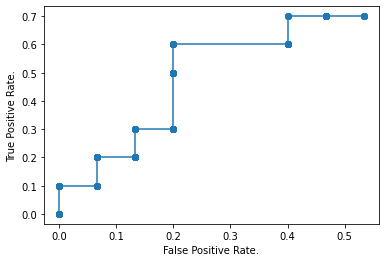

In [376]:
tols = np.linspace(0, 0.5, 500)
tprs, fprs = [], []

B_true = (W_true != 0).flatten()

for tol in tols:       
    B_OMP = (reg_MSE(W_OMP, X, tol) != 0).flatten()

    tprs.append(((B_OMP == B_true) & (B_OMP == 1)).sum() / (B_true == 1).sum())
    fprs.append(((B_OMP != B_true) & (B_OMP == 1)).sum() / (B_true == 0).sum())
    
tprs.append(0)
fprs.append(0)

plt.xlabel("False Positive Rate.")
plt.ylabel("True Positive Rate.")
plt.plot(fprs, tprs, marker = 'o')

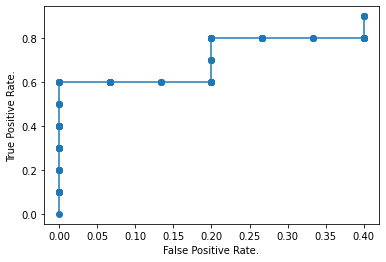

In [373]:
tols = np.linspace(0, 3, 100)
tprs, fprs = [], []

B_true = (W_true != 0).flatten()

for tol in tols:
    B_OMP = (reg_OMP(W_OMP, X, tol) != 0).flatten()
    
    tprs.append(((B_OMP == B_true) & (B_OMP == 1)).sum() / (B_true == 1).sum())
    fprs.append(((B_OMP != B_true) & (B_OMP == 1)).sum() / (B_true == 0).sum())

tprs.append(0)
fprs.append(0)

plt.xlabel("False Positive Rate.")
plt.ylabel("True Positive Rate.")
plt.plot(fprs, tprs, marker = 'o')